<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/medicinely/fwi/blob/main/testcode.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>

In [ ]:
# !git clone https://github.com/medicinely/fwi.git
# %cd fwi

In [53]:
import time
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt

from scipy.optimize import minimize
from func.propagation import prop2d, defmodel
# from func.propagation_tf import simulate_obs
from func.inversion import J,second_order_derivative
from func.velocity_model import check_model, gaussian2d

import cupy as cp
device = 'cpu'

# Mapping function from u to v
def f(u, vmin=2000, vmax=3000):
    # CDF of gaussian
    cdf = sc.stats.norm.cdf(u.flatten(), loc=0, scale=1)
    v = (vmax-vmin) * cdf + vmin
    
    return v.reshape((nz,nx))

# Define cost function
def loglik_fn(u,d_obs,wsrc,zxsrc,zxrec,at,az,ax,next,device,alpha):
	# J: Prior part
	v = f(u)
	log_likelihood = -J(v,d_obs,wsrc,zxsrc,zxrec,at,az,ax,next,device) / alpha
 
	return log_likelihood

# Calculate gradient with Adjoint state method
def dloglik_du_fn(u,d_obs,wsrc,zxsrc,zxrec,at,az,ax,next,device,alpha):
	"""
	Calculate gradiant using adjoint state method
	"""
	# Calculate forward propagated p_fwd(z,x,t) (to update)
	v = f(u)
	nz, nx, nt = len(az), len(ax), len(at)
	if v.ndim == 1: v = np.reshape(v,(nz,nx))
	p_fwd = prop2d(wsrc,zxsrc,v,at,az,ax,next, device)
	receiver_depth = zxrec[0]
	d = p_fwd[zxrec[0], zxrec[1], :]
	residual = d - d_obs # residual shape (n_rec, nt) - residual.shape=(5,801)
	# Calculate back propagated p_back(z,x,t)
	p_back = prop2d(np.flip(residual,axis=1), zxrec, v, at, az, ax, next, device)
	p_back = np.flip(p_back,axis=2)
	# Calculate second order time derivative of p_fwd(z,x,t)
	p_dt_dt = second_order_derivative(p_fwd, at, az, ax)
	# Calculate gradiant
	dJ_dv = 2/v**3  * np.sum(p_back * p_dt_dt, axis=2) # G.shape = (201,201)
	dloglik_dv = -dJ_dv / alpha
	dv_du = sc.misc.derivative(f,u)

	return (dloglik_dv.flatten() * dv_du.flatten()).reshape((nz,nx))

# Variational Bayesian
The objective function evidence lower bound (ELBO) can be written as:

$ELBO(q) = E_q[\log p(d_{obs},v)] - E_q[\log q(v)]$

where $q(v)$ is the variational distribution, $p(d_{obs},v)$ is the joint likelihood of the observed data and model, and $E_q$ denotes the expectation over the variational distribution. The first term encourages the variational distribution to assign high probability to configurations of the model and data that are likely under the true (unknown) posterior distribution, while the second term encourages the variational distribution to be simple and tractable. The objective is to find the variational distribution that maximizes the ELBO.

KL divergence is defined as:

$KL(q(v) || p(v|d_{obs})) = E_q[\log \frac{q(v)}{p(v|d_{obs})}]$

Using Bayes' theorem, we can express the true posterior as:

$p(v|d_{obs}) = \frac{p(d_{obs}|v)p(v)}{p(d_{obs})}$

Substituting this into the definition of the KL divergence gives:

$KL(q(v) || p(v|d_{obs})) = E_q[\log \frac{q(v)}{p(d_{obs}|v)p(v)/p(d_{obs})}]$

$= E_q[\log \frac{q(v)}{p(d_{obs}|v)p(v)}] + \log p(d_{obs})$

The first term on the right-hand side is $-E_q[\log p(v|d_{obs})]$, which is equal to $E_q[\log p(d_{obs},v)] - E_q[\log p(d_{obs})]$. The second term is a constant with respect to $v$, so we can ignore it when optimizing the ELBO with respect to $q(v)$. Thus, minimizing the KL divergence is equivalent to maximizing the ELBO, as we want to get as close as possible to the true posterior.

In [54]:
import time
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt

from scipy.optimize import minimize
from func.propagation import prop2d, defmodel
# from func.propagation_tf import simulate_obs
from func.inversion import J,second_order_derivative
from func.velocity_model import check_model, gaussian2d

import tensorflow as tf
import tensorflow_probability as tfp
print('GPU:',tf.config.list_physical_devices('GPU'))
from func.propagation_tf import simulate_obs

def f_tf(u, vmin=2000, vmax=3000):
    cdf = tfp.distributions.Normal(loc=0, scale=1).cdf(u)
    # cdf =  tf.math.exp(-tf.math.square(u_tf)) / tf.math.sqrt(2.0 * np.pi)
    v = (vmax - vmin) * cdf + vmin
    return v

import pickle
# load data
filename = './data/u_29'
infile = open(filename, 'rb')
u_ref = pickle.load(infile)
infile.close()

filename = './data/Q_29'
infile = open(filename, 'rb')
Q = pickle.load(infile)
infile.close()

GPU: []


dz,dx,dt (m): 8.0 8.0 0.001697056274847714
Model dimension [nz,nx,nt]:  29 29 235
Number of receivers: 104


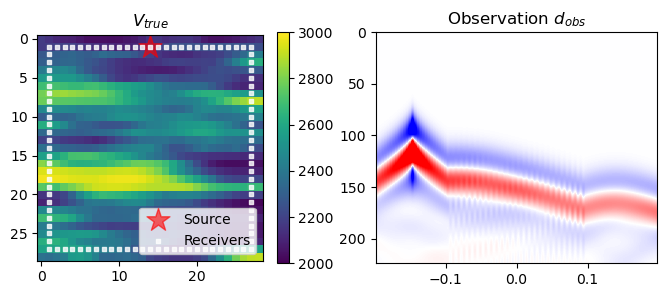

In [55]:
# Initialize the model axis az, ax, at
nz,nx,nt = 29,29,235
vmin,vmax=2000,3000
izsrc, ixsrc = [1], [nx//2]
next = 10

# v_ref = gaussian2d(ranges=[20,5],variance=50,nx=[nz,nx],param=1,mean=2500)
# u_ref, Q = gaussian2d(ranges = [20,5],param=1,nx=[nz,nx],variance=1,mean=0)
v_ref = f(u_ref)

az, ax, at, next, wsrc, zxsrc = defmodel(
                      vmin=vmin, vmax=vmax, fmax=25, # key parameters
                      nz=nz, nx=nx, nt=nt, # number of indices
                      izsrc=izsrc, ixsrc=ixsrc,  # define source coordinates z, x
                      ext=next)  

# check_model(v=v_ref, vmin=vmin, vmax=vmax)
# Set receiver z and x coordinates
interv = 1 # interval between receivers
receivers_width = np.append(np.arange(zxsrc[1][0],0,-interv)[::-1][:-1], #left
							np.arange(zxsrc[1][0],nx-1,interv)) #right
nrec = len(receivers_width)
# zxrec = np.vstack((np.full(nrec, zxsrc[0]), receivers_width)) # Top
zxrec1 = np.vstack((np.full(nrec, zxsrc[0]), receivers_width)) # Top
zxrec2 = np.vstack((np.full(nrec, nz-zxsrc[0]-1), receivers_width)) # Bottom
zxrec3 = np.vstack((receivers_width, np.full(nrec, zxsrc[0]))) # Left
zxrec4 = np.vstack((receivers_width, np.full(nrec, nz-zxsrc[0]-1))) # Right
zxrec = np.hstack((zxrec1,zxrec2,zxrec3,zxrec4))
zxrec = np.unique(zxrec,axis=1)
print("Number of receivers:", len(zxrec.flatten())//2)
d_obs = simulate_obs(f_tf(u_ref), wsrc, zxsrc, at, az, ax, next, zxrec)

plt.figure(figsize=(8,3))
plt.subplot(1,2,1) 
plt.imshow(v_ref,vmin=2000,vmax=3000)
plt.colorbar()
plt.scatter(zxsrc[1,:],zxsrc[0,:],marker='*',color='r',s=300,alpha=0.6,label="Source")
plt.scatter(zxrec[1,:],zxrec[0,:],marker='s',color='w',s=5,alpha=0.8,label="Receivers")
plt.legend(loc='lower right')
plt.title("$V_{true}$")
plt.subplot(1,2,2)
plt.imshow(d_obs.numpy().T,cmap='bwr',vmin=-10,vmax=10,extent=[at[0], at[-1], az[-1], az[0]], aspect='auto')
plt.title("Observation $d_{obs}$")
plt.show()

In [145]:
# Define the number of iterations for the optimization
num_iters = 100
# Define the number of samples for the variational posterior
num_samples = 10

# Define the prior distribution for the model parameters
std_noise = 1
# prior_cov = np.linalg.inv(Q)
prior_mean = tf.zeros([nz, nx], dtype=tf.float32)
prior_cov = 1/Q.diagonal().reshape((nz,nx))
prior_scale = tf.cast(tf.sqrt(prior_cov), dtype=tf.float32)

# Define the likelihood function for the observed data
def log_likelihood_fn(d_obs, u):
    noise_var = std_noise**2  # Assuming Gaussian noise with variance 0.01
    # Calculate J
    d = simulate_obs(f_tf(u), wsrc, zxsrc, at, az, ax, next, zxrec)
    J = .5 * tf.reduce_sum((d - d_obs)**2)
    log_likelihood = - J / noise_var
    # log_likelihood = -J(v,d_obs,wsrc,zxsrc,zxrec,at,az,ax,next,device) / noise_var
    log_likelihood = tf.cast(log_likelihood, tf.float32)
    return log_likelihood

# Define the TensorFlow probability distributions for the likelihood and prior
d_obs_dist = tfp.distributions.MultivariateNormalDiag(loc=d_obs, scale_diag=tf.ones_like(d_obs)*std_noise)
u_prior_dist = tfp.distributions.MultivariateNormalDiag(loc=prior_mean, scale_diag=prior_scale)

# Define the TensorFlow variables for the variational posterior mean and scale
q_mean = tf.Variable(tf.random.normal([nz, nx]), dtype=tf.float32)
# Use Transformed Variable to ensure that the variable remains positive during optimization.
q_scale = tfp.util.TransformedVariable(prior_scale, tfp.bijectors.Exp(), trainable=True)
# Initial q
q_mean = tf.Variable(prior_mean)

# Set up lists to store progress
neg_loglik_history = []
entropy_history = []
neg_elbo_history = []

optimizer = tf.keras.optimizers.Adam()

Start

In [150]:
# Set the learning rate for the optimizer
optimizer.learning_rate = 0.1
print(f"Initial learning rate: {optimizer.learning_rate.numpy()}")

# Train the variational posterior using the ELBO objective
for i in range(num_iters):
    # Print the iteration number
    print(f"Iteration {i + 1}/{num_iters}")
    
    with tf.GradientTape() as tape:
        # Watch the parameters of the variational posterior
        tape.watch([q_mean, q_scale.trainable_variables[0]])
        
        # Sample from the variational posterior
        q_dist = tfp.distributions.MultivariateNormalDiag(loc=q_mean, scale_diag=q_scale)
        
        # Compute the log(d_obs|v) log-likelihood and its gradient
        log_likelihoods = []
        grads_log_likelihoods = []
        for u in u_samples:
            log_likelihoods.append(loglik_fn(u.numpy(),d_obs,*args))
            grads_log_likelihoods.append(dloglik_du_fn(u.numpy(),d_obs,*args))
            
        # Compute the gradient of u with respect to q_mean and q_scale
        with tf.GradientTape() as tape2:
            tape2.watch([q_mean, q_scale.trainable_variables[0]])
            u_samples = q_dist.sample(num_samples)
            du_dq = tape2.gradient(u_samples, [q_mean, q_scale.trainable_variables[0]])
        
        # Compute log likelihoods and grad of log-likelihoods
        E_log_likelihoods = tf.cast(tf.reduce_mean(log_likelihoods), dtype=tf.float32)
        grads_E_log_likelihoods = tf.cast(tf.reduce_mean(grads_log_likelihoods,axis=0) * du_dq, dtype=tf.float32)
        grads_E_log_likelihoods = tf.unstack(grads_E_log_likelihoods, axis=0)
        
        # Compute log(q) entropy terms and gradient of entropy
        log_q = q_dist.log_prob(u_samples)
        E_entropy = tf.reduce_mean(log_q)
        grads_E_entropy = tape.gradient(E_entropy, [q_mean, q_scale.trainable_variables[0]])
        
        # Compute negative ELBO (to minimize)
        neg_elbo = -E_log_likelihoods + E_entropy
        
        # Print and save the values of the neg-log-likelihood, entropy, and negative ELBO
        print(f"Log-likelihood: {-E_log_likelihoods.numpy():.4f}  Entropy: {E_entropy.numpy():.4f}  Negative ELBO: {neg_elbo.numpy():.4f}")
        neg_loglik_history.append(-E_log_likelihoods.numpy())
        entropy_history.append(E_entropy.numpy())
        neg_elbo_history.append(neg_elbo.numpy())

    # Compute gradients of the negative ELBO with respect to q_mean and q_scale
    # and apply them to the optimizer
    grads = [-g for g in grads_E_log_likelihoods] + \
            [-g if g is not None else 0 for g in grads_E_entropy]
    optimizer.apply_gradients(zip(grads, [q_mean, q_scale.trainable_variables[0]]))


Initial learning rate: 0.10000000149011612
Iteration 1/100
Log-likelihood: 2238.5991  Entropy: 18.8771  Negative ELBO: 2257.4761
Iteration 2/100
Log-likelihood: 5124.7144  Entropy: 19.4954  Negative ELBO: 5144.2100
Iteration 3/100
Log-likelihood: 4192.4863  Entropy: 19.4181  Negative ELBO: 4211.9043
Iteration 4/100
Log-likelihood: 3264.0278  Entropy: 19.0765  Negative ELBO: 3283.1042
Iteration 5/100
Log-likelihood: 2206.6755  Entropy: 19.2950  Negative ELBO: 2225.9705
Iteration 6/100
Log-likelihood: 1462.6107  Entropy: 19.0697  Negative ELBO: 1481.6804
Iteration 7/100
Log-likelihood: 920.1095  Entropy: 19.7677  Negative ELBO: 939.8772
Iteration 8/100
Log-likelihood: 668.8932  Entropy: 19.4808  Negative ELBO: 688.3740
Iteration 9/100
Log-likelihood: 600.0277  Entropy: 19.5997  Negative ELBO: 619.6274
Iteration 10/100
Log-likelihood: 682.4536  Entropy: 20.0967  Negative ELBO: 702.5503
Iteration 11/100
Log-likelihood: 806.1265  Entropy: 19.7150  Negative ELBO: 825.8414
Iteration 12/100
Lo

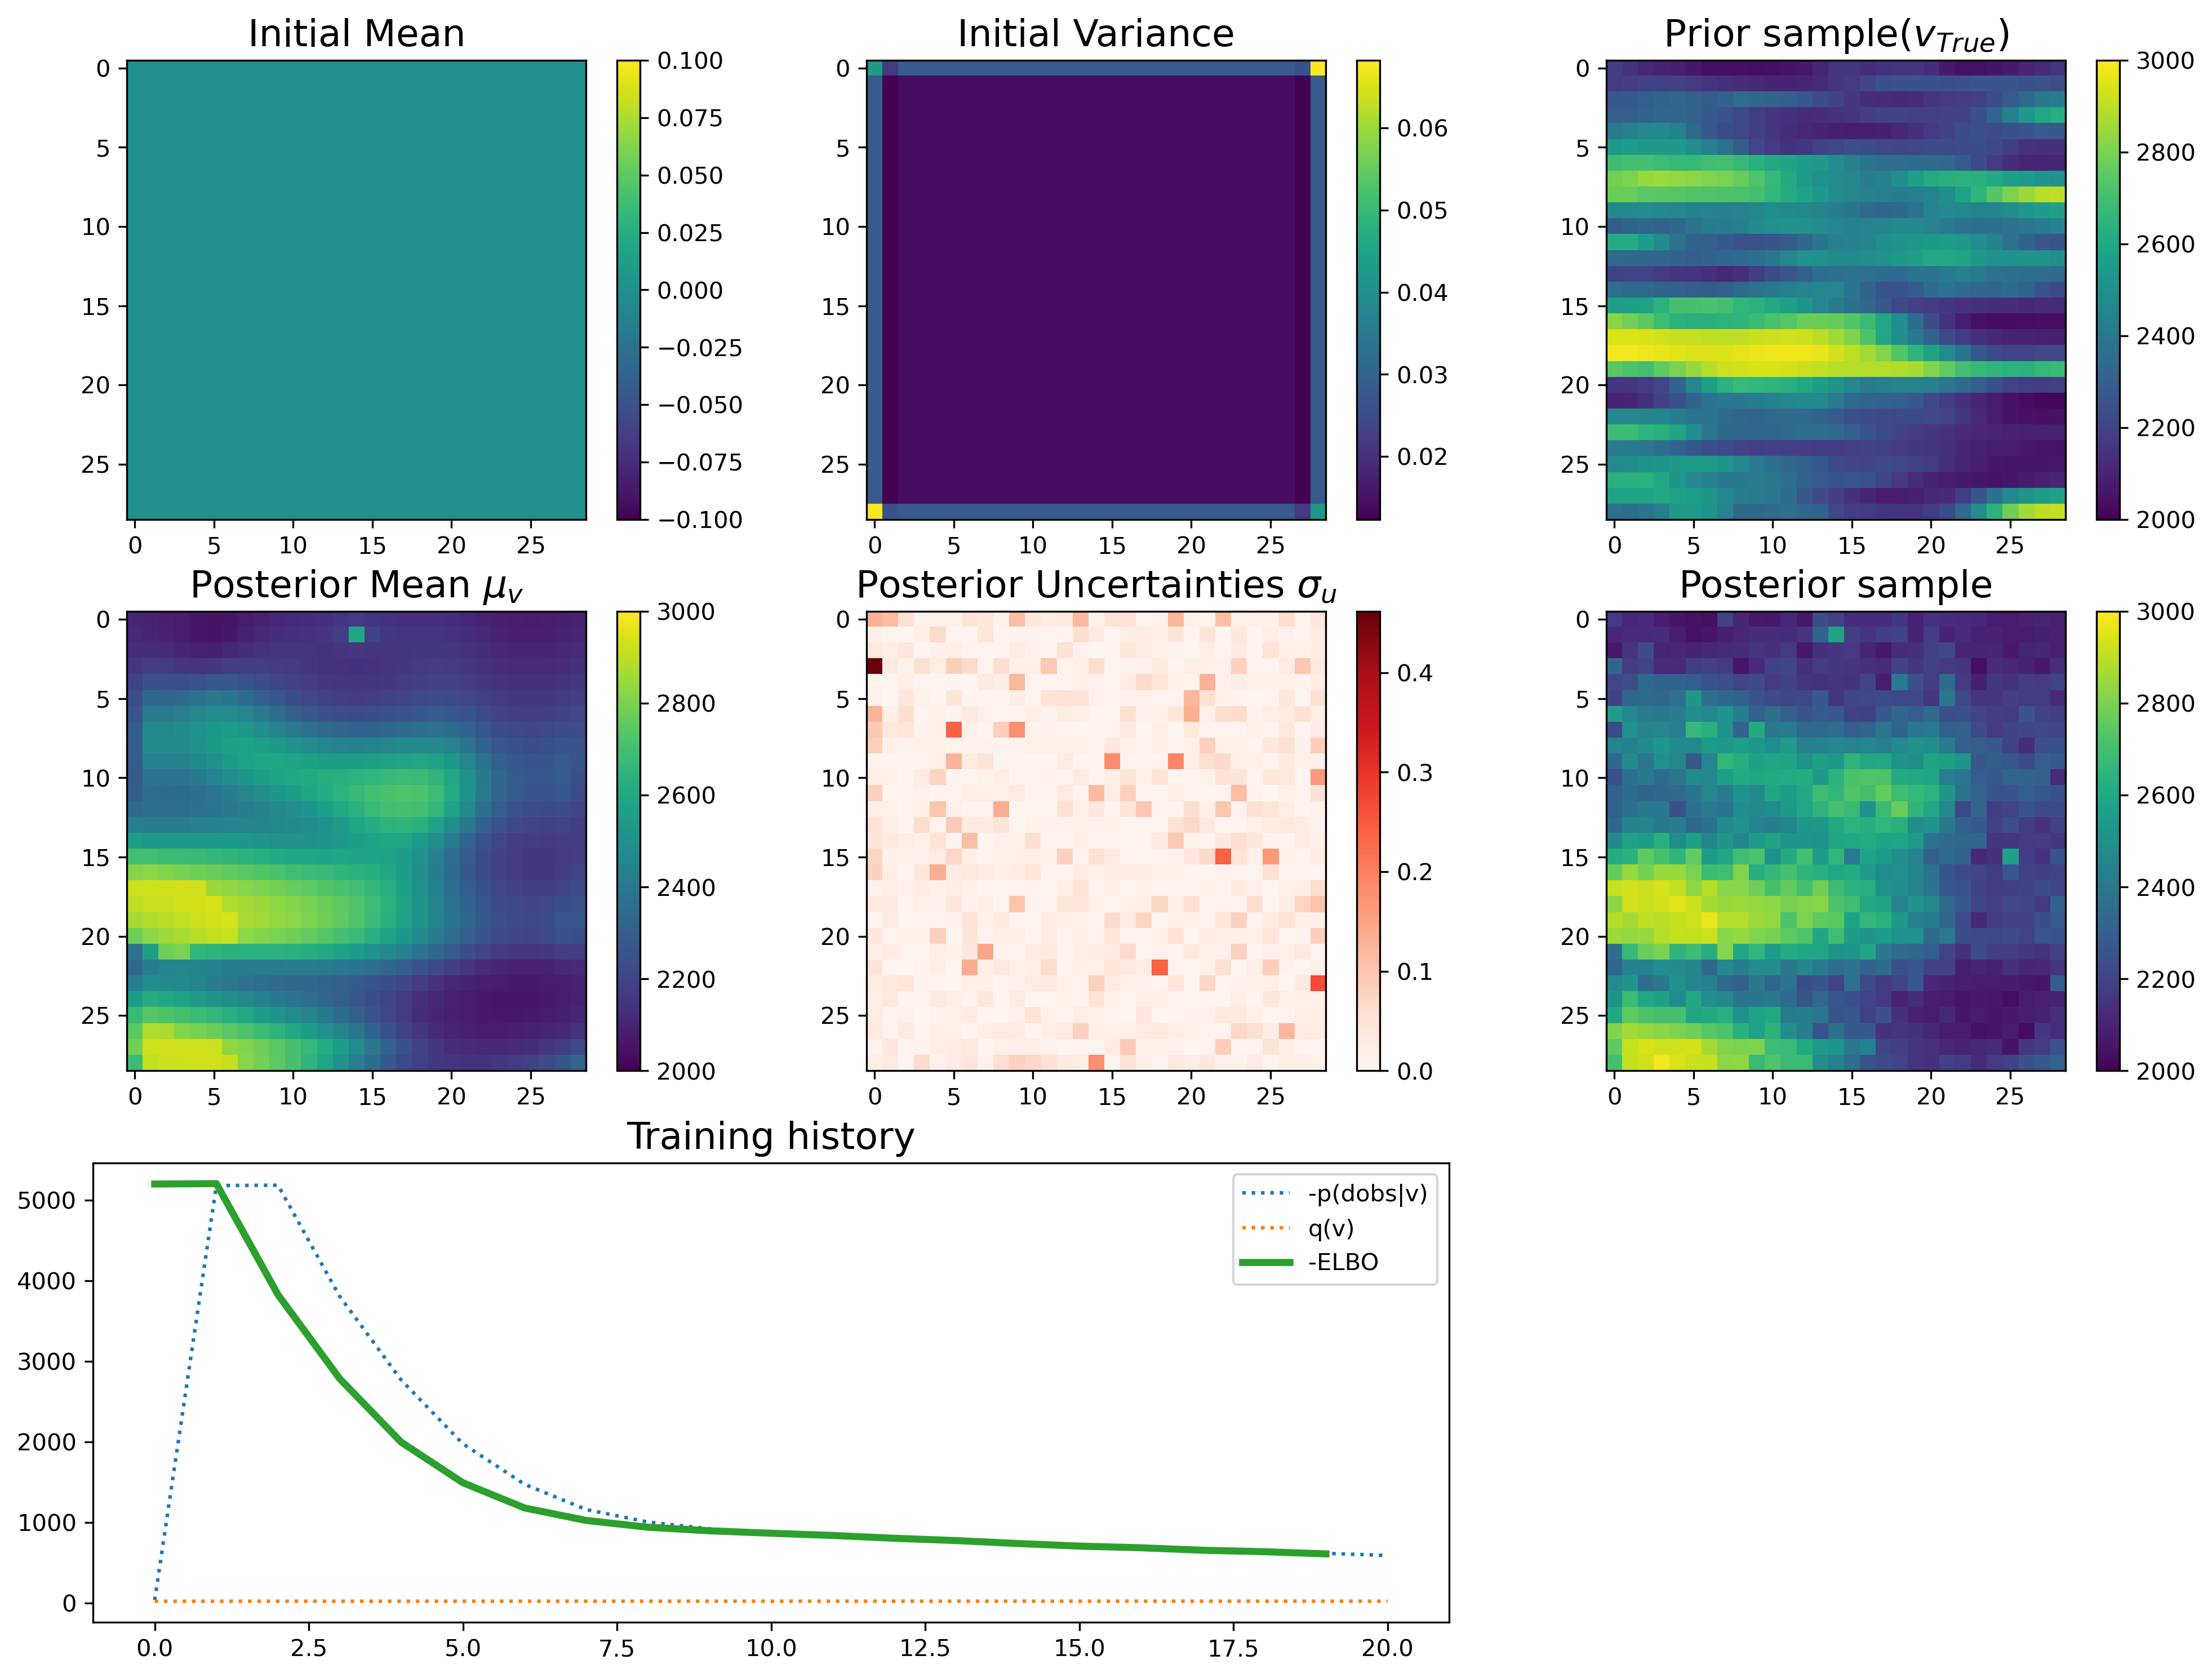

In [124]:
q_posterior = tfp.distributions.MultivariateNormalDiag(loc=q_mean, scale_diag=q_scale)

plt.figure(figsize=(16,12),dpi=300)
plt.subplot(3,3,1)
plt.imshow(u_prior_dist.mean())
plt.colorbar()
plt.title("Initial Mean", fontsize=16)

plt.subplot(3,3,2)
plt.imshow(u_prior_dist.variance())
plt.colorbar()
plt.title("Initial Variance", fontsize=16)

plt.subplot(3,3,3)
plt.imshow(f_tf(u_ref), vmin=2000, vmax=3000)
plt.colorbar()
plt.title("Prior sample($v_{True}$)", fontsize=16)

plt.subplot(3,3,4)
plt.imshow(f_tf(q_posterior.mean()), vmin=2000, vmax=3000)
plt.colorbar()
plt.title("Posterior Mean $\mu_{v}$", fontsize=16)

plt.subplot(3,3,5)
plt.imshow(q_posterior.variance(),cmap='Reds',vmin=0)
plt.colorbar()
plt.title("Posterior Uncertainties $\sigma_{u}$", fontsize=16)

plt.subplot(3,3,6)
plt.imshow(f_tf(q_posterior.sample()), vmin=2000, vmax=3000)
plt.colorbar()
plt.title("Posterior sample", fontsize=16)

plt.subplot(3,3,(7,8))
plt.plot(neg_loglik_history, ls=":", label='-p(dobs|v)')
plt.plot(entropy_history, ls=":", label='q(v)')
plt.plot(neg_elbo_history, lw=3, label='-ELBO')
plt.title("Training history", fontsize=16)
plt.legend()
plt.show()